Medina, Alex - Brightness Phase Curve Complete Code

In [1]:
#General imports
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import pandas as pd
import os

#Important imports
import cv2
import vicar

import skimage.restoration
#To use richardson_lucy deconvolution

This section of the code is exaclty the same as for the polarization, using the circle detection algorithm I made in the past.

In [2]:
def image_center(image):
    #Creating a copy of the image to avoid messing with the original
    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    detected_circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=30, maxRadius=500)

    #Getting center coords for detected circle
    if detected_circles is not None:
        detected_circles = np.round(detected_circles[0, :]).astype("int")
        for (x, y, r) in detected_circles:
            return (x, y)
    else:
        print("No circles found")
        return None
    
#Getting a range of radii and flux to plot for finding optimal radius
def radii_fluxes_from_image(image, center):
    x, y = center
    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    radii = range(1, 1000, 5)
    flux = []

    for r in radii:
        mask = np.zeros_like(gray_image)
        cv2.circle(mask, (x, y), r, (255, 255, 255), -1)
        #Applying mask to the image
        masked = cv2.bitwise_and(gray_image, gray_image, mask=mask)
        flux.append(np.sum(masked))
    return radii, flux

#Visualization of flux and radii for optimal radius
def radii_fluxes_plot(radii, flux):
    plt.plot(radii, flux)
    plt.xlabel("Radius")
    plt.ylabel("Flux")
    plt.title("Flux vs Radius")
    plt.show()

#Finding the optimal radius as before
def optimal_radius_of_image(radii, flux):
    for i in range(1, len(flux)):
        if flux[i] - flux[i-1] < 0.01 * flux[i-1]:
            return radii[i]
    return radii[-1]

Calculating the geometric albedo the same as the basic brightness, however, intead of summing the whole image, summing only whats in the mask.

In [3]:
#Initial test, from ISS User Guide page 138, modified to only use the pixels inside the disk
def geometric_albedo_disk(image, center, radius, pixel_scale):

    mask = np.zeros_like(image)

    #Fills the circle with 1s and the outside is 0
    #So that when we sum, we multiply the image by the mask, and the 0 multiplication
    #Gets ride of eveything outside of the disk
    #And everything inside the disk is summed but stays the same because multiplied by 1
    cv2.circle(mask, center, radius, 1, thickness=-1)

    total_IF = np.sum(image * mask)

    R = 2575  #Titan's radius in km
    n_pixel = np.pi * R**2 / pixel_scale**2

    return total_IF / n_pixel

Inputs - Main difference from basic code is using the PSF file now for deconvolution.

In [4]:
#Path to the folder with the calibrated images
calibrated_images = r'C:\Users\alexi\Desktop\Research\Cassini_Images\CL1_BL2'

#Path to where the .csv file is from, either on Drive or even locally if you choose so
metadata_file = r'C:\Users\alexi\Desktop\Research\Cassini_Images\CL1_BL2\data.csv'


#Loading the PSF file
psf_file_path = r'C:\Users\alexi\Desktop\Research\PSF_files\xpsf_nac_cl1_bl2.img'
psf_vic = vicar.VicarImage(psf_file_path, strict=False)
psf_data = psf_vic.data_2d

#Reading the csv file
parameters_df = pd.read_csv(metadata_file)

The only difference in this loop compared to the bacis brightness code is the addition of the deconvolved image and using the deconvolved images for the caluclation of the geometric albedo. However, it takes a long time to complete.

In [5]:
#Executing a loop to determine all relevant information for plots

geom_albedos = []
phase_angles = []

#Because the .IMG calibrated images don't match 1:1 with the metadata, we have to do some fun things
for filename in os.listdir(calibrated_images):

    #Since we have a loop for each image, each calibrated image universally ends with _CALIB.IMG, so that full path is given as
    if filename.endswith('_CALIB.IMG'):
        calibrated_image_path = os.path.join(calibrated_images, filename)

        #Reading the binary image file using rms-vicar
        vic = vicar.VicarImage(calibrated_image_path, strict=False)
        image = vic.data_2d

        #To perform the deconvolution
        deconvolved_image = skimage.restoration.richardson_lucy(image, psf_data, 30)

        #To get relevant parameters
        opus_id = filename.split('_')[0]
        opus_id_with_prefix = f'co-iss-{opus_id}'.lower()
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id_with_prefix)]

        #For circle detection
        center = image_center(image)
        if center is None:
            continue
        
        radii, fluxes = radii_fluxes_from_image(image, center)
        optimal_radius = optimal_radius_of_image(radii, fluxes)

        if not parameter_row.empty:
            #Assocating the meta data with the image, pixel_scale and phase_angle
            phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
            pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]

            albedo = geometric_albedo_disk(deconvolved_image, center, optimal_radius, pixel_scale)

            #Creating array to plot
            phase_angles.append(phase_angle)
            geom_albedos.append(albedo)

            #For manual inspection and cross referencing of values and .LBL files
            print(f'{filename}: {albedo}')

N1525327484_1_CALIB.IMG: 0.062118705927114895
N1557905313_1_CALIB.IMG: 0.09803076453431946
N1559282826_1_CALIB.IMG: 0.10393364756010363
N1562037473_1_CALIB.IMG: 0.11067079439734676
N1567440211_1_CALIB.IMG: 0.10428596280855278
No circles found
N1571476437_1_CALIB.IMG: 0.050084549711504694
N1578503768_1_CALIB.IMG: 0.07268988310718824
N1617163704_1_CALIB.IMG: 0.03634333019284875
N1617165504_1_CALIB.IMG: 0.03732614195344521
N1644998153_1_CALIB.IMG: 0.09563540614475093
N1645008949_1_CALIB.IMG: 0.09274398558249357
N1645019749_1_CALIB.IMG: 0.0901045392554912
N1646535965_1_CALIB.IMG: 0.08302597300808637
N1671761950_1_CALIB.IMG: 0.053597227355817754
N1671884383_1_CALIB.IMG: 0.04449475208473491
N1687626097_1_CALIB.IMG: 0.11142657031170211
N1725076622_1_CALIB.IMG: 0.05495925652104933
N1732144031_1_CALIB.IMG: 0.07147354628050613
N1848497852_1_CALIB.IMG: 0.042251440000691066
N1849875641_1_CALIB.IMG: 0.04372616087710298
N1849961982_1_CALIB.IMG: 0.04374369247704624
N1850134815_1_CALIB.IMG: 0.04376349

Result

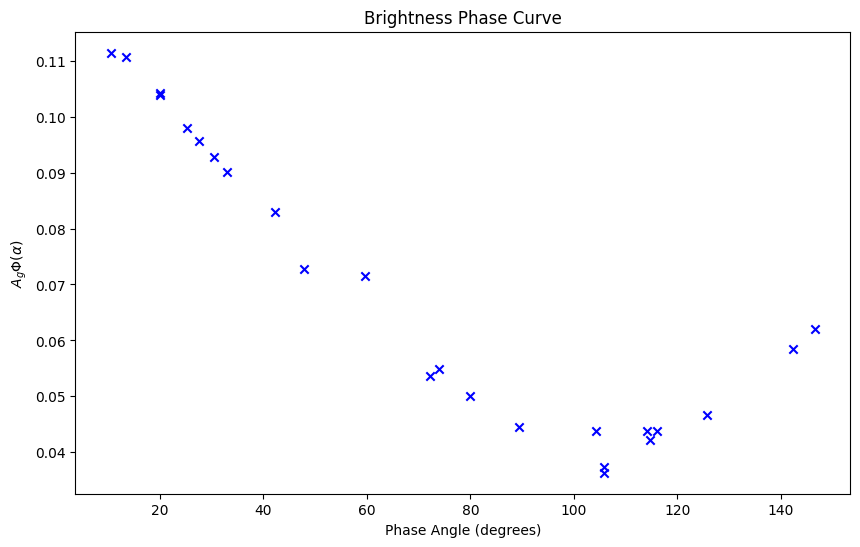

In [6]:
#Initial plot to see where the values range
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, geom_albedos, color='b', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel(r'$A_g \Phi(\alpha)$')
plt.title('Brightness Phase Curve')
plt.show()

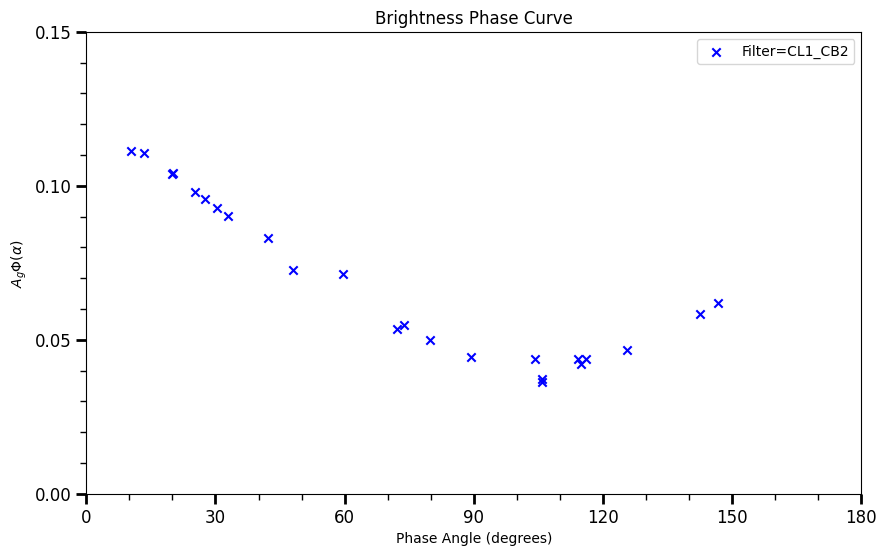

In [8]:
#Fancy plot for consistency across all plots but also visually will look better

filtername = 'CL1_CB2'

#Same size and parameters as before
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, geom_albedos, color='b', marker='x', label=f'Filter={filtername}')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel(r'$A_g \Phi(\alpha)$')
plt.title('Brightness Phase Curve')

#Selecting x-ticks, for them at every 10 but also every 30 will be more pronounces
ax = plt.gca()
ax.set_xticks(range(0, 181, 30))
ax.set_xticks(range(0, 181, 10), minor=True)

ax.tick_params(axis='x', which='major', length=7, width=2, labelsize=12)
ax.tick_params(axis='x', which='minor', length=4, width=1, labelsize=10)

#Same for the y-axis
#While the x-axis is phase so remains consistent, I use above section of code to determine split on for y-axis
#Usually, ticks every 0.05, starts from 0 to the top
ay = plt.gca()
ay.set_yticks([i * 0.05 for i in range(4)], minor=False)
ay.set_yticks([i * 0.01 for i in range(15)], minor=True) 
plt.ylim(0, 0.15)

ay.tick_params(axis='y', which='major', length=7, width=2, labelsize=12)
ay.tick_params(axis='y', which='minor', length=4, width=1, labelsize=10)

plt.legend()
plt.show()